# Fully Connected Neural Network

In this example, we show how one can train a neural network on a specific task (here, Iris Classification) and convert it to its FHE counterpart such that it runs over encrypted data.

In [1]:
import time

import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm import tqdm

from concrete.ml.sklearn import NeuralNetClassifier

### Define all required variables to train the model

In [2]:
# Get iris dataset

X, y = load_iris(return_X_y=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model training and evaluation

In [3]:
params = {
    "module__n_layers": 3,
    "module__n_w_bits": 3,
    "module__n_a_bits": 4,
    "module__n_accum_bits": 10,
    "module__n_outputs": 3,
    "module__input_dim": X.shape[1],
    "module__activation_function": nn.Sigmoid,
    "max_epochs": 1000,
    "verbose": 0,
}
model = NeuralNetClassifier(**params)

In [4]:
model = model.fit(X=X_train.astype(np.float32), y=y_train)
clear_output()

In [5]:
# Evaluate the model
y_pred = model.predict(X_test)
print(f"The test accuracy of the trained model is {(y_pred == y_test).mean()*100:.2f}%")

The test accuracy of the trained model is 89.47%


## FHE Inference

In [6]:
# Compile the model to have before
fhe_circuit = model.compile(X_train)

### Generate the key

In [7]:
print("Generating a key for a " f"{fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for a 8-bit circuit


In [8]:
time_begin = time.time()
fhe_circuit.client.keygen(force=True)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 549.20 seconds


### Predict in FHE

In [9]:
homomorphic_predictions = []
time_begin = time.time()
for x in tqdm(X_test):
    y_ = model.predict(np.array([x]), execute_in_fhe=True)[0]
    homomorphic_predictions.append(y_)

print(f"Execution time: {(time.time() - time_begin) / len(X_test):.2f} seconds per sample")

100%|██████████| 38/38 [08:05<00:00, 12.78s/it]

Execution time: 12.78 seconds per sample


### Print the accuracy of both models

In [10]:
acc_0 = 100 * (y_pred == y_test).mean()
acc_1 = 100 * (homomorphic_predictions == y_test).mean()

print(f"Test Accuracy Inference: {acc_0:.2f}%")
print(f"Test Accuracy Homomorphic Inference: {acc_1:.2f}%")

Test Accuracy Inference: 89.47%
Test Accuracy Homomorphic Inference: 89.47%


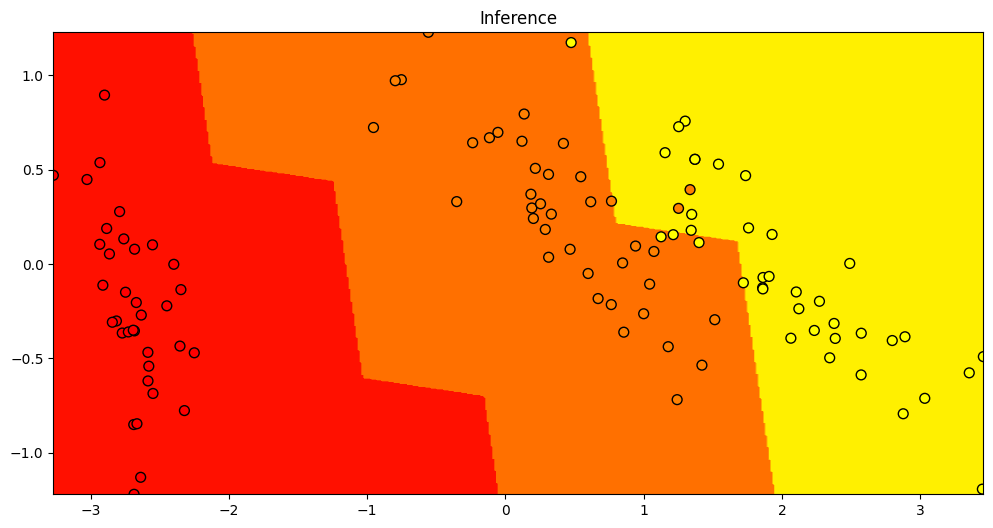

In [11]:
pca = PCA(n_components=2, random_state=np.random.randint(0, 2**15))
X_train_2d = pca.fit_transform(X_train)

b_min = np.min(X_train_2d, axis=0)
b_max = np.max(X_train_2d, axis=0)

grid_dims = tuple(np.linspace(b_min[i], b_max[i], 512) for i in range(X_train_2d.shape[1]))
ndgrid_tuple = np.meshgrid(*grid_dims)
grid_2d = np.vstack([g.ravel() for g in ndgrid_tuple]).transpose()

grid_test = pca.inverse_transform(grid_2d)
grid_pred_all = model.predict_proba(grid_test)

pred_classes = np.argmax(grid_pred_all, axis=1)

%matplotlib inline

cmap = "autumn"

# Create two subplots and set their locations
plt.figure(figsize=(12, 6))

# Plot original model contour plot
plt.contourf(
    ndgrid_tuple[0],
    ndgrid_tuple[1],
    pred_classes.reshape(ndgrid_tuple[0].shape),
    cmap=cmap,
)

# Plot the scatter with marker borders
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, s=50, edgecolors="k", cmap=cmap)

# Add title and axis labels
plt.title("Inference")


plt.show()

While for test data points we predicted the label on encrypted data, to make this demo run faster, the boundaries are predictions made over clear data points. Predictions in FHE are equivalent to those over clear data as we show above.

## Conclusion

In this notebook, we presented a NeuralNetworkClassifier model built with:

- [skorch](https://github.com/skorch-dev/skorch) to have a scikit-learn like API wrapped around [Torch](https://github.com/pytorch/pytorch). 
- [Brevitas](https://github.com/Xilinx/brevitas) which provides low-bit Quantization Aware Training functionality to torch.

The final accuracy of the model in clear can then be expected in FHE (which is what we observe here).
